In [1]:
import pandas as pd
import numpy as numpy

import prepare
import wrangle

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns

# evaluating/modeling methods
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

### 1. Select a dataset with a continuous target variable.

In [2]:
df = wrangle.wrangle_telco()

df.head()

,monthly_charges,total_charges,tenure
customer_id,,,
0013-SMEOE,109.70,7904.25,71
0014-BMAQU,84.65,5377.80,63
0016-QLJIS,90.45,5957.90,65
0017-DINOC,45.20,2460.55,54
0017-IUDMW,116.80,8456.75,72


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1695 entries, 0013-SMEOE to 9995-HOTOH
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   monthly_charges  1695 non-null   float64
 1   total_charges    1695 non-null   float64
 2   tenure           1695 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 53.0+ KB


In [4]:
for column in df.columns:
    print(column.upper())
    print(df[column].value_counts())
    print("-----------------------")

MONTHLY_CHARGES
19.70     21
19.85     21
20.05     19
19.55     18
19.75     17
          ..
114.35     1
88.80      1
63.70      1
29.60      1
95.75      1
Name: monthly_charges, Length: 820, dtype: int64
-----------------------
TOTAL_CHARGES
0.00       10
1110.05     2
5714.20     2
1161.75     2
343.45      2
           ..
7806.50     1
4378.90     1
4677.10     1
641.35      1
400.00      1
Name: total_charges, Length: 1678, dtype: int64
-----------------------
TENURE
72    343
71    137
70     88
69     66
68     65
     ... 
3       3
1       2
5       1
2       1
28      1
Name: tenure, Length: 73, dtype: int64
-----------------------


### 2. Be sure your data is prepared (no missing values, numeric datatypes) and split into samples.

In [5]:
#split data
train, validate, test = prepare.split(df)

train.shape, validate.shape, test.shape

((949, 3), (407, 3), (339, 3))

In [6]:
train.head()

,monthly_charges,total_charges,tenure
customer_id,,,
7501-IWUNG,73.80,4616.05,61
1303-SRDOK,69.05,3842.60,55
3967-VQOGC,24.90,1680.25,67
3777-XROBG,19.55,1079.65,58
5075-JSDKI,24.45,1493.10,59


In [7]:
#set up X inputs and y target variable for each split
X_train = train.drop(columns=['tenure'])
y_train = train.tenure

X_validate = validate.drop(columns=['tenure'])
y_validate = validate.tenure

X_test = test.drop(columns=['tenure'])
y_test = test.tenure

In [8]:
#scale data

#make                            #fit
scaler = MinMaxScaler(copy=True).fit(X_train)

#use
X_train_scaled = scaler.transform(X_train)
X_validate_scaled = scaler.transform(X_validate)
X_test_scaled = scaler.transform(X_test)

In [9]:
X_train_scaled = pd.DataFrame(X_train_scaled, 
                              columns=X_train.columns.values).\
                            set_index([X_train.index.values])

X_validate_scaled = pd.DataFrame(X_validate_scaled, 
                                columns=X_validate.columns.values).\
                            set_index([X_validate.index.values])

X_test_scaled = pd.DataFrame(X_test_scaled, 
                                columns=X_test.columns.values).\
                            set_index([X_test.index.values])
X_train_scaled.head()

,monthly_charges,total_charges
7501-IWUNG,0.552618,0.532410
1303-SRDOK,0.505237,0.443201
3967-VQOGC,0.064838,0.193798
3777-XROBG,0.011471,0.124526
5075-JSDKI,0.060349,0.172213


### 3. Work through all of the steps outlined in the lesson, from setting the baseline to selecting a model and evaluating the final model on your test data.

#### Baseline
- Before beginning to make models, we need to know how well we can estimate (predict) tenure without using any features. 
- This is often done by predicting every observation's target value to be the mean or the median. 
>E.g. we could predict every customer's tenure to be the mean tenure of all the customers in our training sample. We will try both the mean and the median, see which performs best, and set that evaluation metric value as our baseline performance to beat.

In [10]:
type(y_train)

pandas.core.series.Series

In [11]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

# 1. Predict tenure_pred_mean
tenure_pred_mean = y_train.tenure.mean()
y_train['tenure_pred_mean'] = tenure_pred_mean
y_validate['tenure_pred_mean'] = tenure_pred_mean

# 2. Compute tenure_pred_median
tenure_pred_median = y_train.tenure.median()
y_train['tenure_pred_median'] = tenure_pred_median
y_validate['tenure_pred_median'] = tenure_pred_median


# 3. RMSE of tenure_pred_mean
rmse_train = mean_squared_error(y_train.tenure, y_train.tenure_pred_mean) ** .5
rmse_validate = mean_squared_error(y_validate.tenure, y_validate.tenure_pred_mean) ** (1/2)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

print(" ")
# 4. RMSE of tenure_pred_median
rmse_train = mean_squared_error(y_train.tenure, y_train.tenure_pred_median) ** .5
rmse_validate = mean_squared_error(y_train.tenure, y_train.tenure_pred_median) ** .5
print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  18.34 
Validate/Out-of-Sample:  17.66
 
RMSE using Median
Train/In-Sample:  19.82 
Validate/Out-of-Sample:  19.82


- RMSE using mean performs better than the median (it is lower/closer to 0/closer to the line). Using mean RMSE as the baseline also performs better in validate than in train, so it is a good sign.
- Moving forward, we can compare models' RMSE to the mean baseline

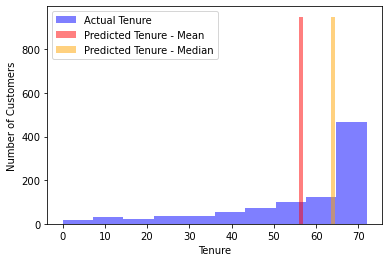

In [12]:
# plot to visualize actual vs predicted. 
plt.hist(y_train.tenure, color='blue', alpha=.5, label="Actual Tenure")
plt.hist(y_train.tenure_pred_mean, bins=1, color='red', alpha=.5, rwidth=100, label="Predicted Tenure - Mean")
plt.hist(y_train.tenure_pred_median, bins=1, color='orange', alpha=.5, rwidth=100, label="Predicted Tenure - Median")
plt.xlabel("Tenure")
plt.ylabel("Number of Customers")
plt.legend()
plt.show()

In [13]:
#incrementally buidling a df for comparison of metrics for model selection
metric_df = pd.DataFrame(data = [{'model': 'mean_baseline', 
                                  'RMSE_validate': rmse_validate,
                                  'r^2_validate': explained_variance_score(y_validate.tenure, y_validate.tenure_pred_mean)}])

metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,19.82032,-2.220446e-16


## LinearRegression (OLS)
1. Fit the model using X_train_scaled and the labels from y_train
2. Predict tenure for customers in training sample using our model (lm)
3. Evaluate using RMSE
4. Repeat predictions and evaluation for validation.
5. Compare RMSE train vs. validation. See if there is overfitting

In [14]:
y_train.head()

,tenure,tenure_pred_mean,tenure_pred_median
customer_id,,,
7501-IWUNG,61,56.495258,64.0
1303-SRDOK,55,56.495258,64.0
3967-VQOGC,67,56.495258,64.0
3777-XROBG,58,56.495258,64.0
5075-JSDKI,59,56.495258,64.0


In [15]:
# make the thing
# create the model object
lm = LinearRegression(normalize=True)

# fit the thing
# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train_scaled, y_train.tenure)


# use the thing!

# predict train
y_train['tenure_pred_lm'] = lm.predict(X_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tenure, y_train.tenure_pred_lm) ** (1/2)


# predict validate
y_validate['tenure_pred_lm'] = lm.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tenure, y_validate.tenure_pred_lm) ** (1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  9.508868775514111 
Validation/Out-of-Sample:  9.72039392233984


In [16]:
#incrementally buidling a df for comparison of metrics for model selection
metric_df = metric_df.append({'model': 'OLS Regressor', 
                              'RMSE_validate': rmse_validate, 
                              'r^2_validate': explained_variance_score(y_validate.tenure, y_validate.tenure_pred_lm)}, ignore_index=True)

metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,19.820320,-2.220446e-16
1,OLS Regressor,9.720394,6.979201e-01


## LassoLars
1. Fit the model using X_train_scaled and the labels from y_train.
2. Predict tenure for customers in training sample using our model (lars).
3. Evaluate using RMSE
4. Repeat predictions and evaluation for validation.
5. Compare RMSE train vs. validation. Overfitting?

In [17]:
# create the model object
lars = LassoLars(alpha=1)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series!
lars.fit(X_train_scaled, y_train.tenure)

# predict train
y_train['tenure_pred_lars'] = lars.predict(X_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tenure, y_train.tenure_pred_lm) ** (1/2)

# predict validate
y_validate['tenure_pred_lars'] = lars.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tenure, y_validate.tenure_pred_lm) ** (1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  9.508868775514111 
Validation/Out-of-Sample:  9.72039392233984


In [18]:
metric_df = metric_df.append({'model': 'Lasso alpha 1', 
                              'RMSE_validate': rmse_validate, 
                              'r^2_validate': explained_variance_score(y_validate.tenure, y_validate.tenure_pred_lars)}, ignore_index=True)

metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,19.820320,-2.220446e-16
1,OLS Regressor,9.720394,6.979201e-01
2,Lasso alpha 1,9.720394,-2.220446e-16


## TweedieRegressor (GLM)
1. Fit the model using X_train_scaled and the labels from y_train.
2. Predict tenure for customers in training sample using our model (glm).
3. Evaluate using RMSE
4. Repeat predictions and evaluation for validation.
5. Compare RMSE train vs. validation. Overfitting?

In [19]:
# create the model object
glm = TweedieRegressor(power=1, alpha=0)


# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train_scaled, y_train.tenure)

# predict train
y_train['tenure_pred_glm'] = glm.predict(X_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tenure, y_train.tenure_pred_glm) ** (1/2)

# predict validate
y_validate['tenure_pred_glm'] = glm.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_train.tenure, y_train.tenure_pred_glm) ** (1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  10.304585364768128 
Validation/Out-of-Sample:  10.304585364768128


In [20]:
metric_df = metric_df.append({'model': 'GLS (Poisson)', 
                              'RMSE_validate': rmse_validate, 
                              'r^2_validate': explained_variance_score(y_validate.tenure, y_validate.tenure_pred_glm)}, ignore_index=True)

metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,19.820320,-2.220446e-16
1,OLS Regressor,9.720394,6.979201e-01
2,Lasso alpha 1,9.720394,-2.220446e-16
3,GLS (Poisson),10.304585,6.596414e-01


## Polynomial Regression
Using sklearn.preprocessing.PolynommialFeatures() + sklearn.linear_model.LinearRegression()

1. Create the new features, based on value indicated for degree for train, validate & test.
2. Fit the Linear Regression model
3. Predict using the transformed (squared or cubed, e.g.) features
4. Evaluate using RMSE
5. Repeat predictions and evaluation for validation.
6. Compare RMSE train vs. validation. Overfitting?

In [21]:
## Polynomial Features ##
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train_scaled)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate_scaled)
X_test_degree2 =  pf.transform(X_test_scaled)


## LinearRegression ##
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_scaled, y_train.tenure)

# predict train
y_train['tenure_pred_lm2'] = lm2.predict(X_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tenure, y_train.tenure_pred_lm2) ** (1/2)

# predict validate
y_validate['tenure_pred_lm2'] = lm2.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tenure, y_validate.tenure_pred_lm2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  9.508868775514111 
Validation/Out-of-Sample:  94.48605800546129


In [22]:
metric_df = metric_df.append({'model': 'Quadratic Model', 
                              'RMSE_validate': rmse_validate, 
                              'r^2_validate': explained_variance_score(y_validate.tenure, y_validate.tenure_pred_lm2)}, ignore_index=True)

metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,19.820320,-2.220446e-16
1,OLS Regressor,9.720394,6.979201e-01
2,Lasso alpha 1,9.720394,-2.220446e-16
3,GLS (Poisson),10.304585,6.596414e-01
4,Quadratic Model,94.486058,6.979201e-01


## Evaluate
#### Plotting Actual vs. Predicted Values

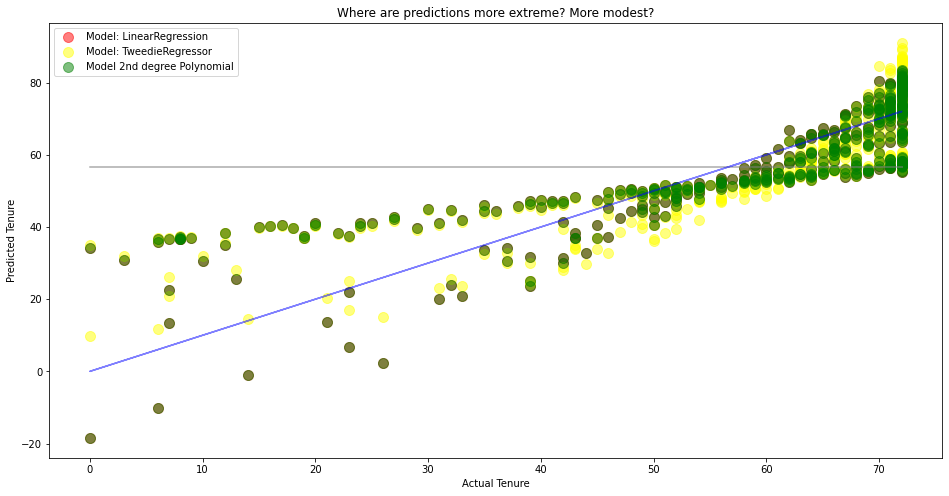

In [28]:
# y_validate.head()
plt.figure(figsize=(16,8))

plt.plot(y_validate.tenure, y_validate.tenure_pred_mean, alpha=.5, color="gray", label='_nolegend_')

plt.plot(y_validate.tenure, y_validate.tenure, alpha=.5, color="blue", label='_nolegend_')

plt.scatter(y_validate.tenure, y_validate.tenure_pred_lm, 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.tenure, y_validate.tenure_pred_glm, 
            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.tenure, y_validate.tenure_pred_lm2, 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Tenure")
plt.ylabel("Predicted Tenure")
plt.title("Where are predictions more extreme? More modest?")

plt.show()

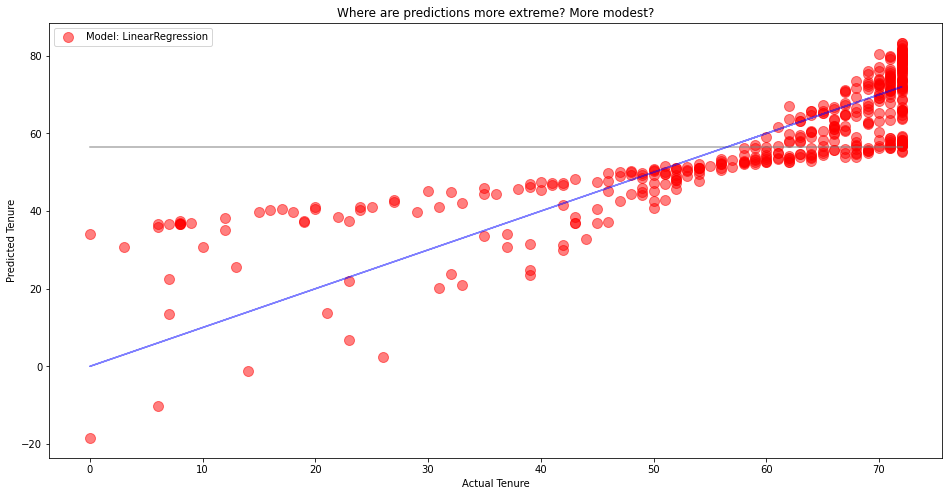

In [25]:
# y_validate.head()
plt.figure(figsize=(16,8))

plt.plot(y_validate.tenure, y_validate.tenure_pred_mean, alpha=.5, color="gray", label='_nolegend_')

plt.plot(y_validate.tenure, y_validate.tenure, alpha=.5, color="blue", label='_nolegend_')

plt.scatter(y_validate.tenure, y_validate.tenure_pred_lm, 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
#plt.scatter(y_validate.tenure, y_validate.tenure_pred_glm, 
#            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
#plt.scatter(y_validate.tenure, y_validate.tenure_pred_lm2, 
#            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Tenure")
plt.ylabel("Predicted Tenure")
plt.title("Where are predictions more extreme? More modest?")

plt.show()

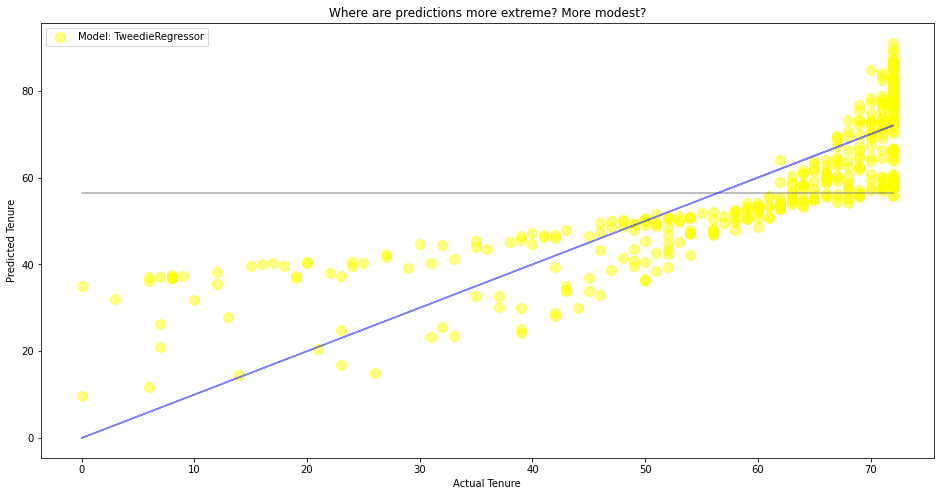

In [26]:
# y_validate.head()
plt.figure(figsize=(16,8))

plt.plot(y_validate.tenure, y_validate.tenure_pred_mean, alpha=.5, color="gray", label='_nolegend_')

plt.plot(y_validate.tenure, y_validate.tenure, alpha=.5, color="blue", label='_nolegend_')

#plt.scatter(y_validate.tenure, y_validate.tenure_pred_lm, 
#            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.tenure, y_validate.tenure_pred_glm, 
            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
#plt.scatter(y_validate.tenure, y_validate.tenure_pred_lm2, 
#            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Tenure")
plt.ylabel("Predicted Tenure")
plt.title("Where are predictions more extreme? More modest?")

plt.show()

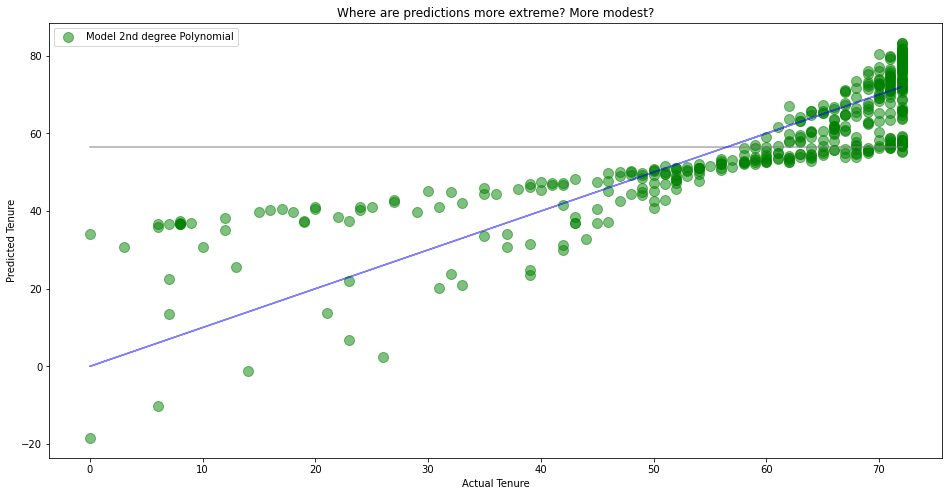

In [27]:
# y_validate.head()
plt.figure(figsize=(16,8))

plt.plot(y_validate.tenure, y_validate.tenure_pred_mean, alpha=.5, color="gray", label='_nolegend_')

plt.plot(y_validate.tenure, y_validate.tenure, alpha=.5, color="blue", label='_nolegend_')

#plt.scatter(y_validate.tenure, y_validate.tenure_pred_lm, 
#            alpha=.5, color="red", s=100, label="Model: LinearRegression")
#plt.scatter(y_validate.tenure, y_validate.tenure_pred_glm, 
#            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.tenure, y_validate.tenure_pred_lm2, 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Tenure")
plt.ylabel("Predicted Tenure")
plt.title("Where are predictions more extreme? More modest?")

plt.show()

#### Residual Plots: Plotting the Errors in Predictions

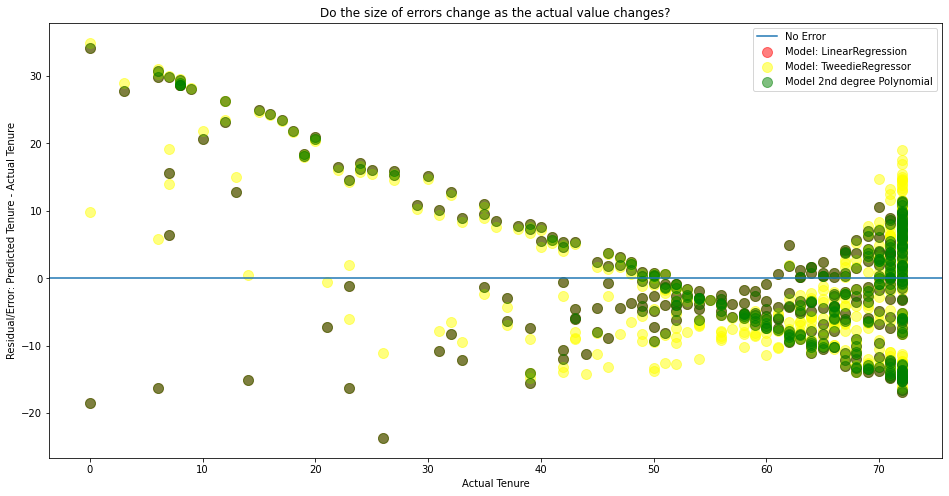

In [29]:
# y_validate.head()
plt.figure(figsize=(16,8))

plt.axhline(label="No Error")

plt.scatter(y_validate.tenure, y_validate.tenure_pred_lm - y_validate.tenure , 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.tenure, y_validate.tenure_pred_glm - y_validate.tenure, 
            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.tenure, y_validate.tenure_pred_lm2 - y_validate.tenure, 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Tenure")
plt.ylabel("Residual/Error: Predicted Tenure - Actual Tenure")
plt.title("Do the size of errors change as the actual value changes?")

plt.show()

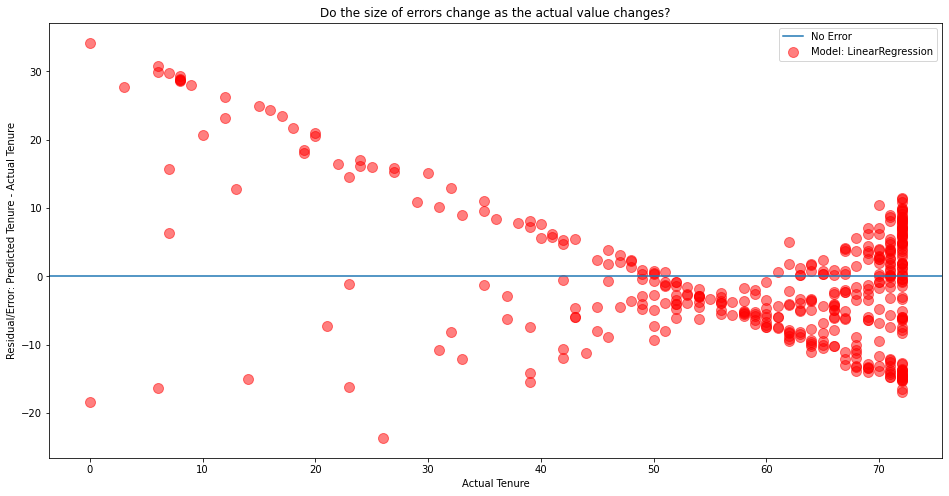

In [30]:
# y_validate.head()
plt.figure(figsize=(16,8))

plt.axhline(label="No Error")

plt.scatter(y_validate.tenure, y_validate.tenure_pred_lm - y_validate.tenure , 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
#plt.scatter(y_validate.tenure, y_validate.tenure_pred_glm - y_validate.tenure, 
#            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
#plt.scatter(y_validate.tenure, y_validate.tenure_pred_lm2 - y_validate.tenure, 
#            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Tenure")
plt.ylabel("Residual/Error: Predicted Tenure - Actual Tenure")
plt.title("Do the size of errors change as the actual value changes?")

plt.show()

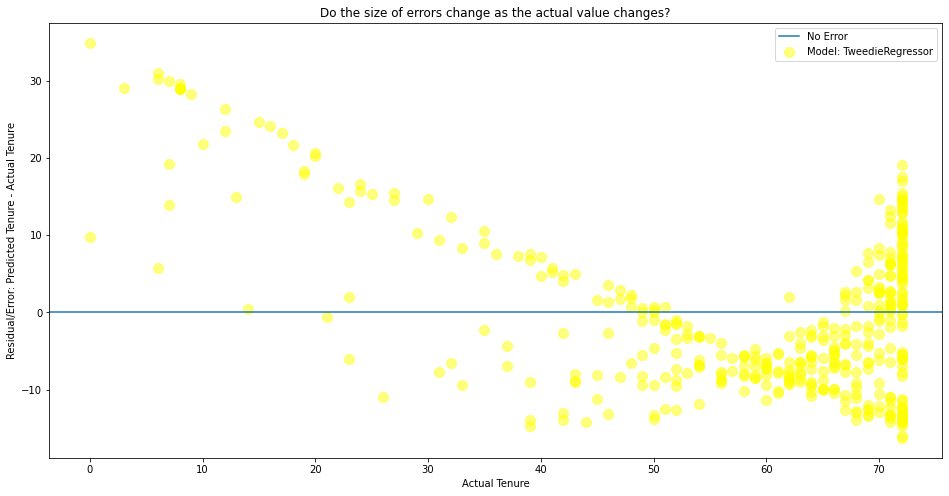

In [31]:
# y_validate.head()
plt.figure(figsize=(16,8))

plt.axhline(label="No Error")

#plt.scatter(y_validate.tenure, y_validate.tenure_pred_lm - y_validate.tenure , 
#            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.tenure, y_validate.tenure_pred_glm - y_validate.tenure, 
            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
#plt.scatter(y_validate.tenure, y_validate.tenure_pred_lm2 - y_validate.tenure, 
#            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Tenure")
plt.ylabel("Residual/Error: Predicted Tenure - Actual Tenure")
plt.title("Do the size of errors change as the actual value changes?")

plt.show()

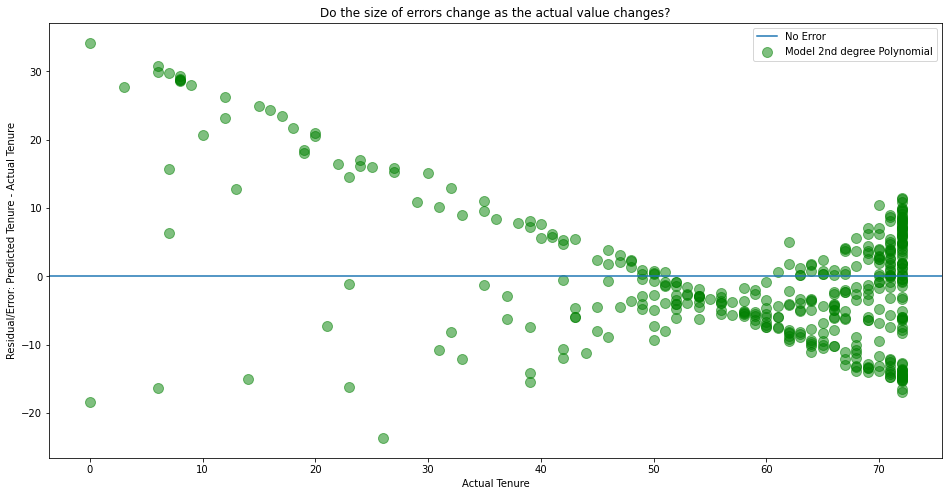

In [32]:
# y_validate.head()
plt.figure(figsize=(16,8))

plt.axhline(label="No Error")

#plt.scatter(y_validate.tenure, y_validate.tenure_pred_lm - y_validate.tenure , 
#            alpha=.5, color="red", s=100, label="Model: LinearRegression")
#plt.scatter(y_validate.tenure, y_validate.tenure_pred_glm - y_validate.tenure, 
#            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.tenure, y_validate.tenure_pred_lm2 - y_validate.tenure, 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Tenure")
plt.ylabel("Residual/Error: Predicted Tenure - Actual Tenure")
plt.title("Do the size of errors change as the actual value changes?")

plt.show()

#### Histogram

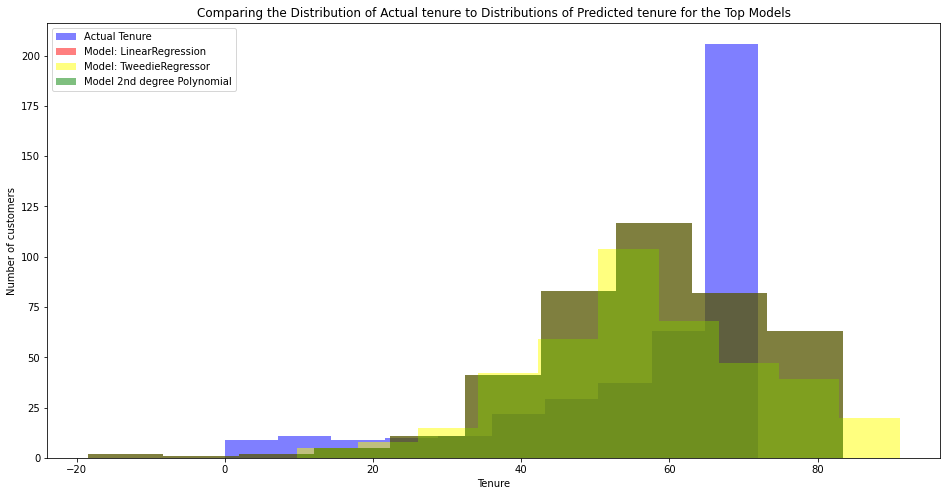

In [33]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,8))

plt.hist(y_validate.tenure, color='blue', alpha=.5, label="Actual Tenure")
plt.hist(y_validate.tenure_pred_lm, color='red', alpha=.5, label="Model: LinearRegression")
plt.hist(y_validate.tenure_pred_glm, color='yellow', alpha=.5, label="Model: TweedieRegressor")
plt.hist(y_validate.tenure_pred_lm2, color='green', alpha=.5, label="Model 2nd degree Polynomial")
plt.xlabel("Tenure")
plt.ylabel("Number of customers")
plt.title("Comparing the Distribution of Actual tenure to Distributions of Predicted tenure for the Top Models")
plt.legend()
plt.show()

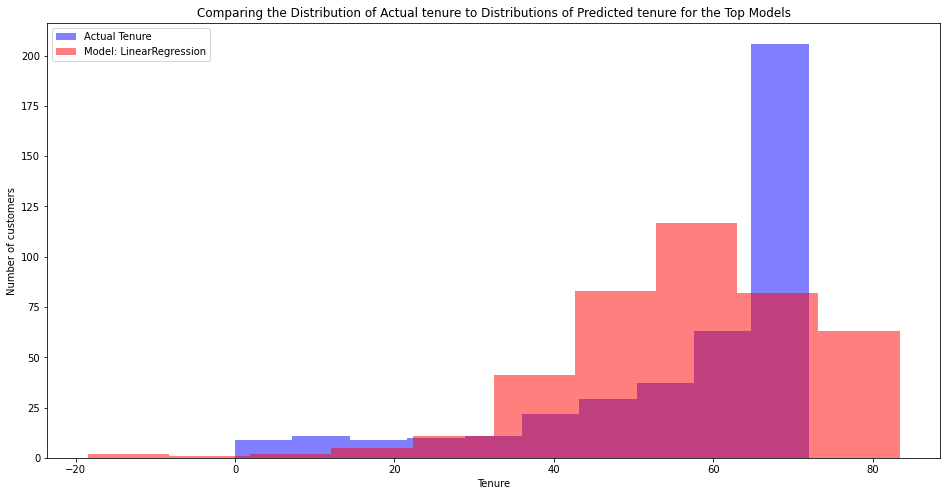

In [34]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,8))

plt.hist(y_validate.tenure, color='blue', alpha=.5, label="Actual Tenure")
plt.hist(y_validate.tenure_pred_lm, color='red', alpha=.5, label="Model: LinearRegression")
#plt.hist(y_validate.tenure_pred_glm, color='yellow', alpha=.5, label="Model: TweedieRegressor")
#plt.hist(y_validate.tenure_pred_lm2, color='green', alpha=.5, label="Model 2nd degree Polynomial")
plt.xlabel("Tenure")
plt.ylabel("Number of customers")
plt.title("Comparing the Distribution of Actual tenure to Distributions of Predicted tenure for the Top Models")
plt.legend()
plt.show()

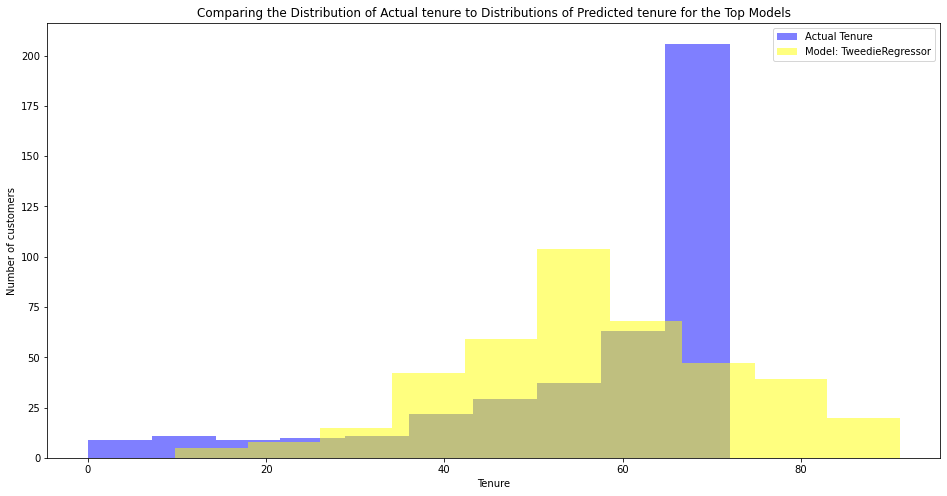

In [35]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,8))

plt.hist(y_validate.tenure, color='blue', alpha=.5, label="Actual Tenure")
#plt.hist(y_validate.tenure_pred_lm, color='red', alpha=.5, label="Model: LinearRegression")
plt.hist(y_validate.tenure_pred_glm, color='yellow', alpha=.5, label="Model: TweedieRegressor")
#plt.hist(y_validate.tenure_pred_lm2, color='green', alpha=.5, label="Model 2nd degree Polynomial")
plt.xlabel("Tenure")
plt.ylabel("Number of customers")
plt.title("Comparing the Distribution of Actual tenure to Distributions of Predicted tenure for the Top Models")
plt.legend()
plt.show()

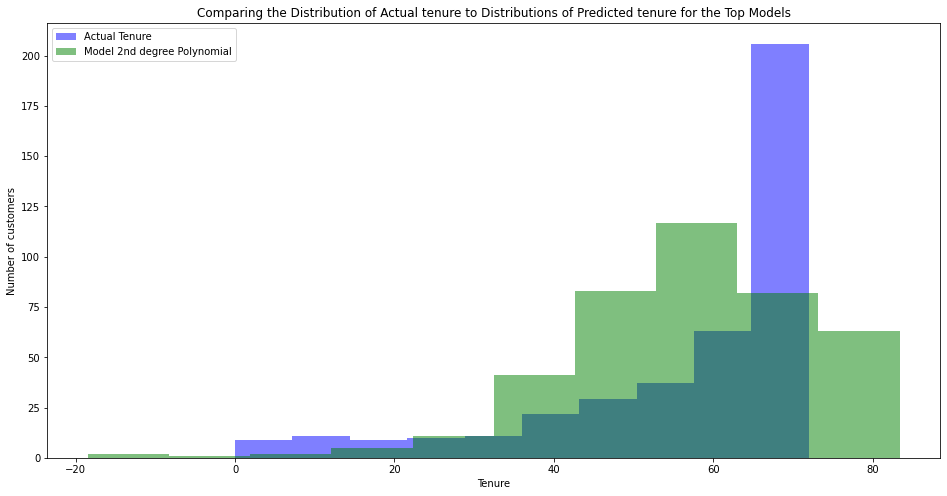

In [36]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,8))

plt.hist(y_validate.tenure, color='blue', alpha=.5, label="Actual Tenure")
#plt.hist(y_validate.tenure_pred_lm, color='red', alpha=.5, label="Model: LinearRegression")
#plt.hist(y_validate.tenure_pred_glm, color='yellow', alpha=.5, label="Model: TweedieRegressor")
plt.hist(y_validate.tenure_pred_lm2, color='green', alpha=.5, label="Model 2nd degree Polynomial")
plt.xlabel("Tenure")
plt.ylabel("Number of customers")
plt.title("Comparing the Distribution of Actual tenure to Distributions of Predicted tenure for the Top Models")
plt.legend()
plt.show()

#### Model Selection & Out-of-Sample Evaluation

Model selected: lm (using LinearRegression)

In [37]:
y_test = pd.DataFrame(y_test)

# predict on test
y_test['tenure_pred_lm'] = lm.predict(X_test_scaled)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.tenure, y_test.tenure_pred_lm) ** (1/2)

print("RMSE for OLS Model using LinearRegression\nOut-of-Sample Performance: ", rmse_test)

RMSE for OLS Model using LinearRegression
Out-of-Sample Performance:  10.079746863483207
